# Regressor Model for Predicting Cognitive Scores

Try both ADAS11 and MMSE

In [1]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

import numpy as np
import pandas as pd
from scipy.io import loadmat

### Get Features (FC Matrices)

In [2]:
ADNI_MERGE = '../data/ADNIMERGE_29Apr2024_wFiles.csv'

df = pd.read_csv(ADNI_MERGE)
df = df[['RID', 'VISCODE', 'ADAS11', 'MMSE', 'DX', 'DX_bl', 'FC_DATA']]
df = df.dropna(subset=['MMSE'])

df.head()

,RID,VISCODE,ADAS11,MMSE,DX,DX_bl,FC_DATA
0,5280,M024,2.0,30.0,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI100S5280_ses-M024...
1,5265,M024,5.0,28.0,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI007S5265_ses-M024...
2,5262,M000,4.0,29.0,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI018S5262_ses-M000...
3,5250,M000,7.0,29.0,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI018S5250_ses-M000...
4,5242,M000,5.0,29.0,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI019S5242_ses-M000...


In [3]:
def compute_fc_lower_triangle(fmri, node_size):
    # Calculate the z_score (along the time axis)
    fmri_zscored = (fmri.T - fmri.mean(axis=1)) / fmri.std(axis=1)

    # Calculate the FC 
    fc = np.corrcoef(fmri_zscored.T)
    
    # Get the lower triangle
    mask_e = np.tril_indices(node_size, -1)
    lower_triangle = fc[mask_e]
    
    return lower_triangle

In [4]:
dim_x = len(df)
X = []
NODE_SIZE = 100

for i, file in enumerate(df['FC_DATA'].values):
    arr = loadmat(f'../{file}')['ROI_activity'][:NODE_SIZE, :] # get the first 100 regions
    fc = compute_fc_lower_triangle(arr, NODE_SIZE)
    X.append(fc)
    
X = np.array(X)
print(X.shape)

Y = df['MMSE']
print(Y.shape)

(1341, 4950)
(1341,)


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Train Regressor Model

In [6]:
def getGBMRegressor():
    #Configure GBM regression model
    params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 3,
              'learning_rate': 0.01, 'loss': 'huber', 'subsample': 0.2}
    reg = GradientBoostingRegressor(**params)
    return reg, 'gbm'

def getRFRegressor():
    return  RandomForestRegressor(n_estimators=500, max_depth=None, random_state=0, bootstrap=True), 'rf'

In [7]:
reg, type = getGBMRegressor()  
reg.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=5,
                          min_samples_split=3, n_estimators=500, subsample=0.2)

In [8]:
y_pred = reg.predict(X_test)
mae = np.mean(np.abs(Y_test - y_pred))
spearman_rho = spearmanr(y_pred, Y_test)[0]
r2_score = r2_score(Y_test, y_pred)

print('METRICS FOR GBM REGRESSOR MODEL (MMSE Scores):')
print('MAE: ', mae)
print('Spearman rho: ', spearman_rho)
print('R2: ', r2_score)

METRICS FOR GBM REGRESSOR MODEL (MMSE Scores):
MAE:  2.1478228789613145
Spearman rho:  0.2363478973656073
R2:  0.024715159043527057


Text(0.5, 1.0, 'GBM Regressor: MMSE Predictions')

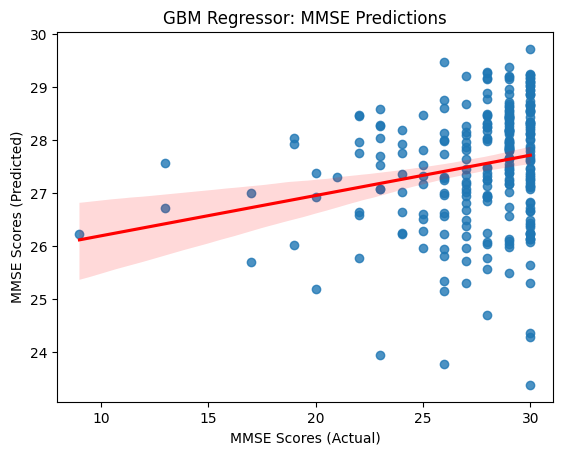

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x=Y_test, y=y_pred, line_kws={'color':'red'})
plt.xlabel('MMSE Scores (Actual)')  
plt.ylabel('MMSE Scores (Predicted)') 
plt.title('GBM Regressor: MMSE Predictions')  

# plt.savefig('mmse_gbm_regressor_pred.png')
